In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras import models, layers, losses, optimizers
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
(X_train,y_train),(X_test, y_test) = datasets.cifar10.load_data()

Comienzo importando el set de datos y mostrando una imagen de sample.

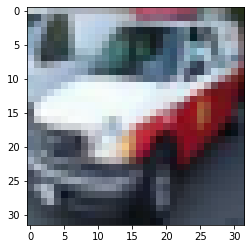

In [ ]:
plt.imshow(X_train[60])
plt.show()

In [ ]:
X_train.shape

(50000, 32, 32, 3)

El conjunto de entrenamiento está compuesto por una lista de 50.000 items que poseen, a su vez, 32X32 items repartidos en 3 valores (RGB).

In [ ]:
#Normalizo el rango de datos a rango 0-1 para evitar que altos valores faciliten problemas de gradiente.

X_train_norm = X_train/255
X_test_norm = X_test/255

#Convierto la columna y a categorica

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


In [ ]:
model_tf = models.Sequential()
model_tf.add(layers.Flatten(input_shape=(32, 32, 3))) # dimensión del dataset de entrada
model_tf.add(layers.Dense(128,activation="relu")) #primera capa de activación lineal con 128 nodos
model_tf.add(layers.Dense(64,activation="relu")) #segunda capa de activación relu con 64 nodos
model_tf.add(layers.Dense(10,activation="softmax")) #Capa de output del modelo; son 10 dimensiones debido a la cantidad de labels que tiene el dataset. Por otro lado, utilizo la activación softmax debido a que
                                                    #es una variable categórica.

model_tf.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 3072)              0         
                                                                 
 dense_15 (Dense)            (None, 128)               393344    
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 10)                650       
                                                                 
Total params: 402,250
Trainable params: 402,250
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_tf.compile(
    optimizer="sgd", #Optimizador Stochastic Gradient Descent
    loss="categorical_crossentropy", #criterio de perdida corss entropy
    metrics=["mse","accuracy"] #Medidas de evaluación: MSE y Accuracy
)


In [ ]:
#Genero modelo con 100 iteraciones (epochs =100)

history = model_tf.fit(
    X_train_norm, y_train_cat,
    epochs=100,
    batch_size=16,
    validation_split=0.2
)


Epoch 1/100
2500/2500 [==============================] - 8s 3ms/step - loss: 1.8938 - mse: 0.0798 - accuracy: 0.3178 - val_loss: 1.7705 - val_mse: 0.0761 - val_accuracy: 0.3750
Epoch 2/100
2500/2500 [==============================] - 7s 3ms/step - loss: 1.7129 - mse: 0.0744 - accuracy: 0.3862 - val_loss: 1.6661 - val_mse: 0.0728 - val_accuracy: 0.4089
Epoch 3/100
2500/2500 [==============================] - 7s 3ms/step - loss: 1.6332 - mse: 0.0718 - accuracy: 0.4171 - val_loss: 1.7074 - val_mse: 0.0742 - val_accuracy: 0.3868
Epoch 4/100
2500/2500 [==============================] - 7s 3ms/step - loss: 1.5780 - mse: 0.0699 - accuracy: 0.4378 - val_loss: 1.6108 - val_mse: 0.0707 - val_accuracy: 0.4279
Epoch 5/100
2500/2500 [==============================] - 7s 3ms/step - loss: 1.5328 - mse: 0.0683 - accuracy: 0.4524 - val_loss: 1.6280 - val_mse: 0.0718 - val_accuracy: 0.4107
Epoch 6/100
2500/2500 [==============================] - 7s 3ms/step - loss: 1.4960 - mse: 0.0671 - accuracy: 0.465

Una vez generado el modelo, se puede notar cómo a medida que el modelo va aumentando en su iteración, el accuracy crece mientras que el loss decrece. Esto se debe al mecanismo de back propagation por el cual se actualizan los pesos con base en los errores generados en cada paso con el fin de optimizar la función de coste.

A pesar de lo anterior, la información de validación no es satisfactoria. Cabría continuar investigando el modelo y encontrar algún modo de regularización que permita que la mejora en cada iteración se refleje también el set de validación y de esta forma evitar el aparente overfitting que el modelo actual comete.

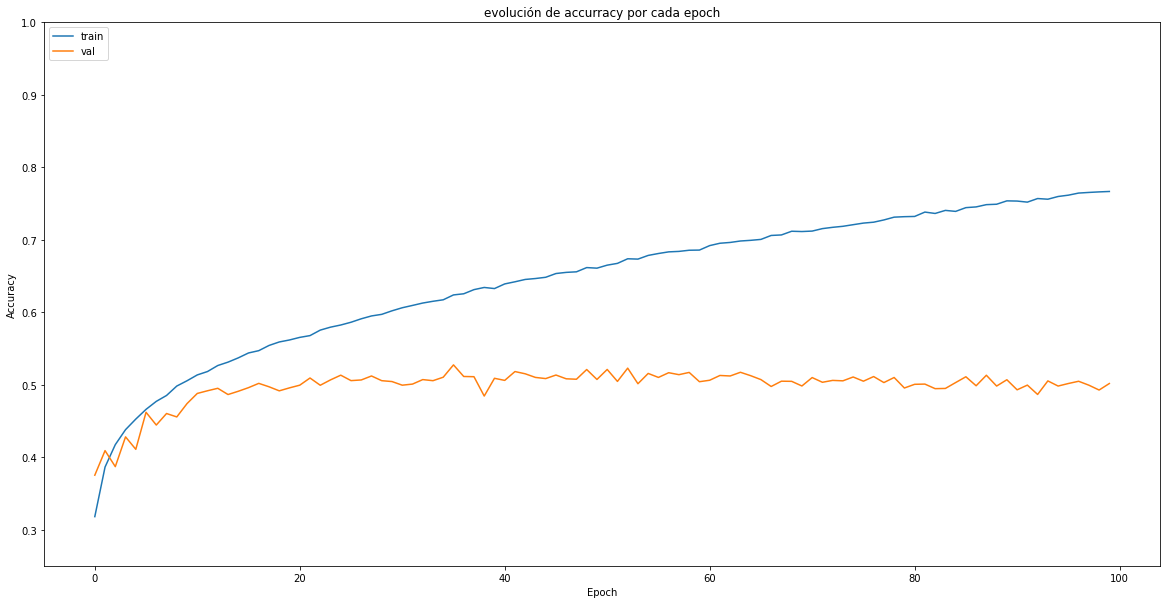

In [ ]:
#genero grafica de evolución de accurracy por cada iteración.
plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("evolución de accurracy por cada epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0.25, 1])
plt.show()

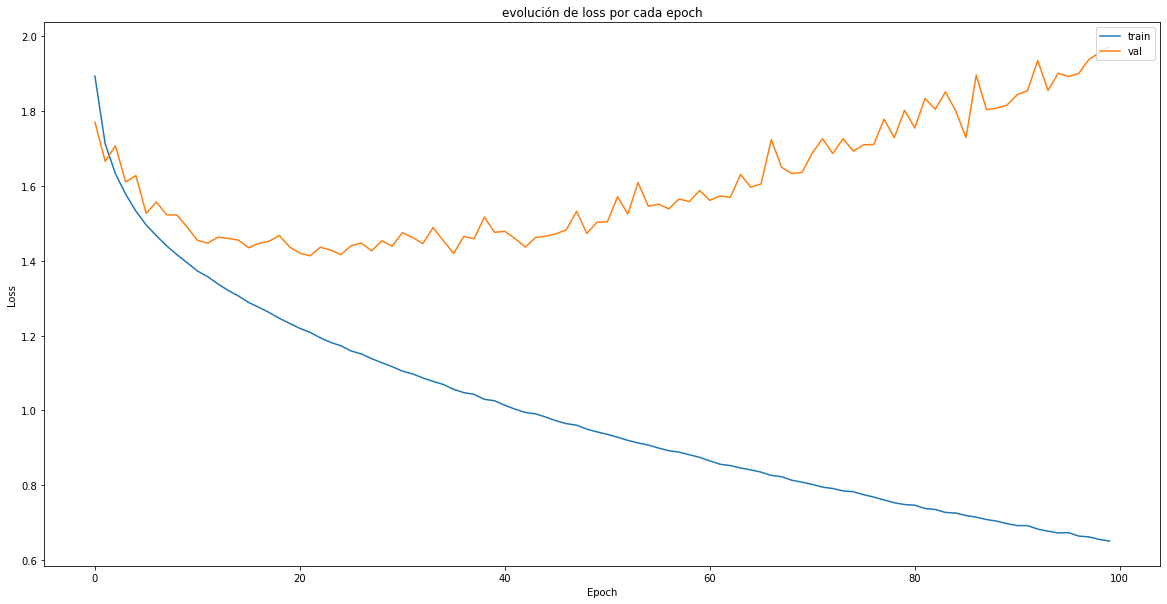

In [ ]:
#genero grafica de evolución del loss por cada iteración.
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.title("evolución de loss por cada epoch")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Con el modelo actual generado, procedo a predecir los valores del subconjunto de testeo.

In [ ]:
y_pred = model_tf.predict(X_test_norm)

test_loss, test_mse, test_accurracy = model_tf.evaluate(X_test_norm, y_test_cat)

313/313 [==============================] - 1s 2ms/step - loss: 1.9603 - mse: 0.0728 - accuracy: 0.4933


In [ ]:
print(y_pred[1],"\n----------")
print(y_pred[1].sum())

[6.5178347e-01 4.2828489e-03 2.8241312e-04 2.2190884e-06 1.7690996e-05
 1.7027987e-05 3.2915128e-08 1.2802477e-04 3.3873582e-01 4.7504185e-03] 
----------
0.99999994


Se puede notar que tanto la pérdida como la accuracy del modelo al predecir los datos de testing empeoran notoriamente en comparación con los datos arrojados por el conjunto de entrenamiento, situándose en valores similares a los del conjuntod e validación.

Yendo a verificar el tipo de output de las predicciones, se puede ver que por ejemplo, para la primer imagen del data set se consiguen las probabilidades de que sea cualquiera de las 10 labels con las que se entrenó al modelo y la sumatoria de dichas probabilidades es igual a 1.

Aún mas, si se quisiera generar una matriz de confusión tomando el valor máximo de probabilidad de cada elemento, el resultado sería el que se muestra debajo (donde se puede notar que en algunas clases el modelo predice mejor que en otras).

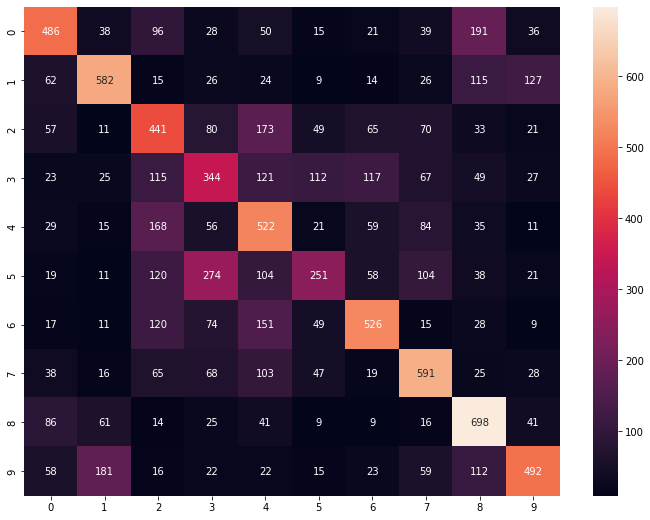

In [ ]:
confusion_mtx = tf.math.confusion_matrix(np.argmax(y_test_cat, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(12, 9))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g')


# PyTorch

In [ ]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

Para el caso de Pytorch comienzo generando un transform que permita normalizar las datos.

Una vez realizado lo anterior, cargo el set de entrenamiento y lo subdivido entre validación y train. Para hacer lo anterior, genero un random split del trainset original de forma tal que queden 45 mil observaciones en el train set y 5 mil en el val set.

In [ ]:
#Obtención del set de train
trainset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=transform)
#Partición de set train entre train y validación
train_ds, val_ds = random_split(trainset, [len(trainset)-5000, 5000])
print(len(train_ds), len(val_ds))

#Creación del train y val loader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = 16, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size = 32, pin_memory=True)

# Generación del set de testing
testset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=False, transform=transform)
# Test loader
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
45000 5000
Files already downloaded and verified


A partir de lo anterior, genero la clase model_pt1 donde se incluyen 3 capas lineales: 2 con nodos de entrada y salida siguiendo lo solicitado por el enunciado del ejercicio y una capa final con 10 dimensiones de salida (ya que son las 10 clases que se querrán predecir).

A su vez, en el forward de la clase genero funciones de activación ReLU entre capa y capa siguiendo con lo solicitado en el ejercicio.]

In [ ]:
class Model_pt1(nn.Module):
    def __init__(self):
      super().__init__()
      # self.flat = nn.Flatten()
      self.fc1 = nn.Linear(3072, 128) # inicialización
      self.fc2 = nn.Linear(128, 64) # inicialización
      self.fc3 = nn.Linear(64,10) # inicialización

    def forward(self, x):
      x = x.view(x.size(0),-1)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      x= F.relu(x)
      x = self.fc3(x)
      return x

model_pt1 = Model_pt1() # llamamos al constructor únicamente
print(model_pt1)

Model_pt1(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
optimizer = optim.SGD(model_pt1.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

En este punto entreno al modelo. Para generar trazabilidad sobre los valores de epoch, loss y accuracy (tanto para test como para validación) creo un dataframe que se irá nutriendo de los datos arrojados por cada iteración de epoch.

In [ ]:
epochs = 100
model_pt1.train()

loss_acc = pd.DataFrame(columns=["epoch","train_loss","train_acc","val_loss","val_acc"])

for e in range(epochs):
  running_loss = 0
  total= 0
  correct = 0
  running_loss_val = 0
  total_val = 0
  correct_val = 0

  print("Epoch: {}".format(e))

  #Genero un diccionario para ir almacenando los valores de la iteración
  fila = dict()
  fila["epoch"] = e

  #Iteración sobre datos de training
  for x_train, y_train in train_loader:
    #Gradiente
    optimizer.zero_grad()
    # Forward
    logits = model_pt1(x_train)
    # Calculo del loss
    loss = criterion(logits, y_train)
    # Gradiente a partir de la pérdida
    loss.backward()
    # Actualización de pesos por backpropagation
    optimizer.step()
    # Genero variables de loss, total y correct para calculos de accuracy y loss
    _, y_pred = torch.max(logits.data, 1)
    total += y_train.size(0)
    correct += (y_pred == y_train).sum().item()
    running_loss += loss.item()

  #Iteración sobre datos de validación
  for x_val, y_val in val_loader:
    #Gradiente
    optimizer.zero_grad()
    # Forward
    logits = model_pt1(x_val)
    # Calculo del loss
    loss = criterion(logits, y_val)
    # Gradiente a partir de la pérdida
    loss.backward()
    #  Actualización de pesos por backpropagation
    optimizer.step()
    # Genero variables de loss, total y correct para calculos de accuracy y loss
    _val, y_pred_val = torch.max(logits.data, 1)
    total_val += y_val.size(0)
    correct_val += (y_pred_val == y_val).sum().item()
    running_loss_val += loss.item()

  #Genero las variables de loss y accuracy para posteriormente ir alimentando el diccionary
  #Dicho diccionary a su vez se anexará al dataframe generado inicialmente.

  train_loss = running_loss / len(train_loader)
  fila["train_loss"] = train_loss
  acc= correct/total
  fila["train_acc"] = acc
  val_loss = running_loss_val / len(val_loader)
  fila["val_loss"] = val_loss
  acc_val = correct_val/total_val
  fila["val_acc"] = acc_val
  print(fila)
  loss_acc = loss_acc.append(fila, ignore_index= True)

Epoch: 0
{'epoch': 0, 'train_loss': 1.7219549971799855, 'train_acc': 0.3938888888888889, 'val_loss': 1.7375272914862177, 'val_acc': 0.3952}
Epoch: 1
{'epoch': 1, 'train_loss': 1.7167414828123166, 'train_acc': 0.3967333333333333, 'val_loss': 1.732544184490374, 'val_acc': 0.3972}
Epoch: 2
{'epoch': 2, 'train_loss': 1.7116026799957649, 'train_acc': 0.39853333333333335, 'val_loss': 1.7276296342254445, 'val_acc': 0.3972}
Epoch: 3
{'epoch': 3, 'train_loss': 1.7067380318046677, 'train_acc': 0.4003333333333333, 'val_loss': 1.7229881104390332, 'val_acc': 0.3984}
Epoch: 4
{'epoch': 4, 'train_loss': 1.701778321557735, 'train_acc': 0.40175555555555553, 'val_loss': 1.7185192723183116, 'val_acc': 0.3982}
Epoch: 5
{'epoch': 5, 'train_loss': 1.6971597435039598, 'train_acc': 0.40328888888888886, 'val_loss': 1.7138185303681974, 'val_acc': 0.3982}
Epoch: 6
{'epoch': 6, 'train_loss': 1.6924080796992698, 'train_acc': 0.40455555555555556, 'val_loss': 1.7096180293210752, 'val_acc': 0.401}
Epoch: 7
{'epoch': 

Una vez finalizada la iteración de entrenamiento del modelo, se puede ver que el dataframe quedó con los valores correctamente guardaos y fácilmente se podrán utilizar para graficar las curvas de loss/accuracy.

In [ ]:
loss_acc.tail()

,epoch,train_loss,train_acc,val_loss,val_acc
95,95.0,1.456802,0.489289,1.501463,0.4734
96,96.0,1.454879,0.490067,1.499893,0.4738
97,97.0,1.453068,0.490667,1.498352,0.4742
98,98.0,1.450978,0.491600,1.496767,0.4754
99,99.0,1.449367,0.492400,1.495426,0.4764


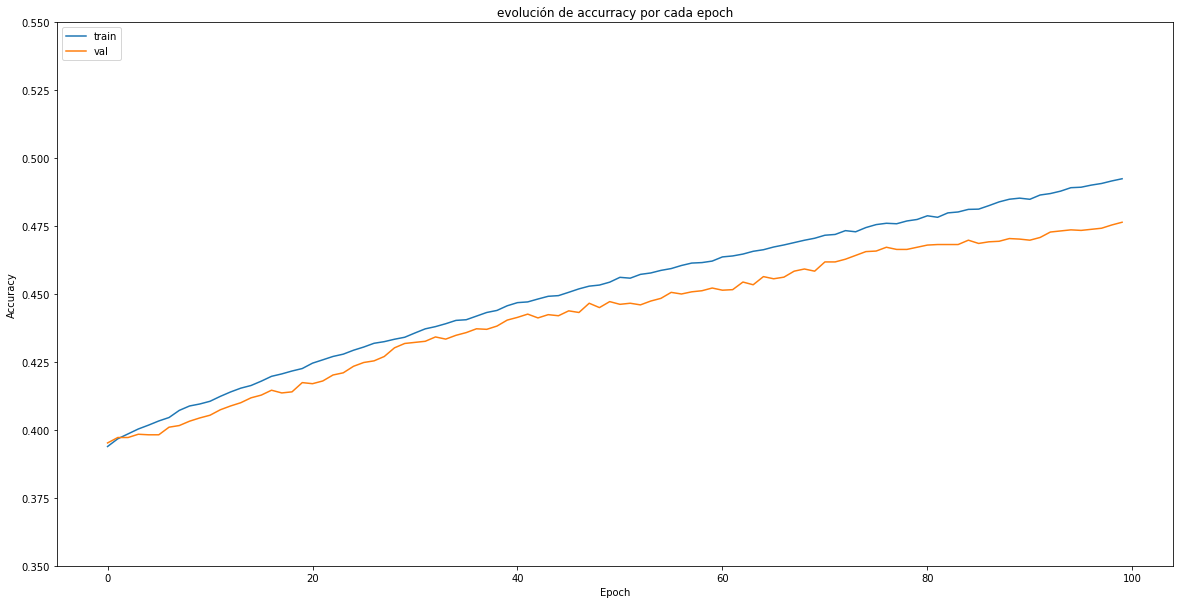

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_acc["train_acc"])
plt.plot(loss_acc["val_acc"])
plt.title("evolución de accurracy por cada epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0.35, 0.55])
plt.show()

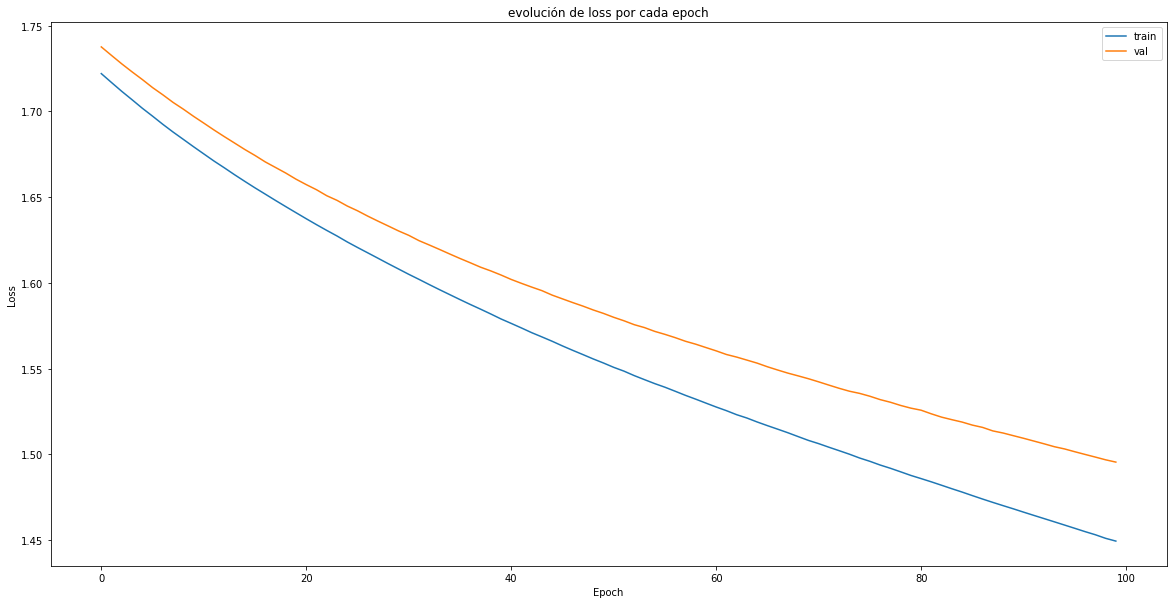

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_acc["train_loss"], label = 'train')
plt.plot(loss_acc["val_loss"], label = 'val')
plt.title("evolución de loss por cada epoch")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
correct = 0
total = 0
# deshabilitamos el cálculo de gradientes; tb vale model_pt.eval()
with torch.no_grad():
  for x_test, y_test in testloader:
    logits = model_pt1(x_test) # ejecuta el método forward
    # escogemos la clase con mayor valor
    _, y_pred = torch.max(logits.data, 1)
    total += y_test.size(0)
    correct += (y_pred == y_test).sum().item()

print(f'Accuracy del modelo sobre el dataset de prueba: {100 * correct / total}%')

Accuracy del modelo sobre el dataset de prueba: 47.85%


Por último, se puede notar la accuracy del modelo sobre los datos de testing.

En este caso, el accuracy se encuentra en una franja de valores similares a sus datos de entrenamiento y validación. Se podría decir entonces que el poder de generalización del modelo es bueno, aunque su capacidad predictiva debe ser mejorada.